In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import pandas as pd
import folium
import datetime as dt
import dateutil.parser
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
tf.__version__
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


# Dataset Processing

In [3]:
#------------------------------------------------------------------------------#
#                               Data Processing                                #



# This is an object class to store all the data about storms :) 
class storm(object):

  def __init__(self,name,sid,lat,longi,basin,sub_basin,times,wind,pres): 
    # Note: the lat, long, times, wind, and pres are all arrays across the duration of a storm! 
    self.sid = sid # unique ID number associated with year/number of storm 
    self.name = name # Hurricane Name
    self.lat = lat # Hurricane Latitude, array of all 
    self.longi = longi # Hurricane Longitude, array of all 
    self.basin = basin # Hurricane basin, by 2-lettter code 
    self.sub_basin = sub_basin
    self.times = times #Hurricane times 
    self.wind = wind 
    self.pres = pres

  def Get_Maxs(this):
    maxLat = max(this.lat)
    maxLong = max(this.longi)
    maxWind = max(this.wind)
    maxPres = max(this.pres)
    return maxLat, maxLong, maxWind, maxPres

  def Get_Mins(this):
    minLat = min(this.lat)
    minLong = min(this.longi)
    minWind = min(this.wind)
    minPres = min(this.pres)
    return minLat, minLong, minWind, minPres


  def CleanStorm(this,interval):
    toRemove = []
    i = 1
    lastCleanTime = this.times[0]
    # check if the last correct time minus the current time is in the correct interval
    while(i < len(this.times)):
      nextTime = this.times[i]
      tDelta = nextTime - lastCleanTime
      if tDelta == interval:
        lastCleanTime = nextTime
      else:
        toRemove.append(i)
      i += 1

    # reverse sort to not mess up the indices 
    toRemove.sort(reverse=True)

    # Remove the bad data
    for r in toRemove:
      this.times.pop(r)
      this.longi.pop(r)
      this.lat.pop(r)
      this.wind.pop(r)
      this.pres.pop(r)      

# This function sorts imported data into storms :) 
def stormify(dataset):
  storm_list = []
  item = dataset[0] 

  stormno = item[2]
  name = item[5] 
  sid = str(item[1]*1000 + item[2])
  lat = []
  longi = []
  basin = str.strip(item[3])
  sub_basin = str.strip(item[4])
  times = []
  wind = []
  pres = []
  for item in dataset: 
    # Case 1 - New storm 
    # Create an object for the old storm, re-initialize everything 
    if (item[2] != stormno):
      """    print('Name', name)
      print('SID', sid)
      print('Basin', basin)
      print('Lat', lat)
      print('Long', longi)
      print('Times', times)
      print('Wind', wind)
      print('Pres', pres) """
      # Create an object for the given SID 
      storm_list.append(storm(name, sid, lat, longi, basin,sub_basin, times, wind, pres))
      # Reset Values with new data
      stormno = item[2]
      name = item[5] 
      sid = str(item[1]*1000 + item[2])
      lat = [item[8]]
      longi = [item[9]]
      basin = str.strip(item[3])
      sub_basin = str.strip(item[4])
      times = [dateutil.parser.parse(item[6])]
      wind = [item[10]]
      pres = [item[11]]
    # Case 2 - Same old storm 
    else:
      lat.append(item[8])
      longi.append(item[9])
      times.append(dateutil.parser.parse(item[6]))
      wind.append(item[10])
      pres.append(item[11])

  return storm_list

def normalize(x, mx, mn):
  return (x-mn)/(mx-mn)

def normalize_col(col,maxV,minV):
  for i in range(len(col)):
    col[i] = normalize(col[i],maxV,minV)
  return col

def normalize_storms(storms):
  maxLats = []
  maxLongs = []
  maxWinds = []
  maxPress = []

  minLats = []
  minLongs = []
  minWinds = []
  minPress = []

  for s in storms:
    maLa , maLo , maWi, maPr = s.Get_Maxs()
    maxLats.append(maLa)
    maxLongs.append(maLo)
    maxWinds.append(maWi)
    maxPress.append(maPr)

    miLa, miLo, miWi, miPr = s.Get_Mins()
    minLats.append(miLa)
    minLongs.append(miLo)
    minWinds.append(miWi)
    minPress.append(miPr)

  maxs = [max(maxLats),max(maxLongs),max(maxWinds),max(maxPress)]
  mins = [min(minLats),min(minLongs),min(minWinds),min(minPress)]

  for s in storms:
    s.lat = normalize_col(s.lat,maxs[0],mins[0])
    s.longi = normalize_col(s.longi,maxs[1],mins[1])
    s.wind = normalize_col(s.wind,maxs[2],mins[2])
    s.pres = normalize_col(s.pres,maxs[3],mins[3])

  return storms, maxs, mins

def remove_small_storms(storm_list,cutoff):
  refined_storms = []
  for storm in storm_list:
    if len(storm.longi) >= cutoff:
      refined_storms.append(storm)
  return refined_storms 

def get_orgnaised_storm(storm,size):
  #basin_codes = ["","SE","SI","SP","EP","WP","NA","NI","SA"]
  #sub_basin_codes = ["","MM","WA","EA","CP","NA","GM","CS","BB","AS"]
  datas = []
  labels_lat = []
  labels_long = []
  labels_wind = []
  labels_pres = []

  #basin = basin_codes.index(storm.basin)
  #sub_basin = sub_basin_codes.index(storm.sub_basin)

  lats = storm.lat
  longs = storm.longi

  winds = storm.wind
  press = storm.pres
  
  length = len(winds)
  for i in range((length+1)-size):
    new_data = []
    for j in range(size-1):
      index = j + i

      new_data.append(lats[index])
      new_data.append(longs[index])

      new_data.append(winds[index])
      new_data.append(press[index])

    label_index = i + size - 1 

    datas.append(new_data)
    labels_lat.append(lats[label_index])
    labels_long.append(longs[label_index])
    labels_wind.append(winds[label_index])
    labels_pres.append(press[label_index])

  return datas, labels_lat, labels_long, labels_wind, labels_pres

def create_organised_data(storm_list, stormSize):
  data_x      = [] # lat_t0|long_t0|wnd_t0|pres_t0|lat_t1|long_t1|wnd_t1|pres_t1|...
  data_y_lat  = [] # lat at next interval 
  data_y_long = []
  data_y_wind = []
  data_y_pres = []

  for storm in storm_list:
    x, yLat, yLong, yWind, yPres = get_orgnaised_storm(storm,stormSize)
    data_x = data_x + x
    data_y_lat = data_y_lat + yLat
    data_y_long = data_y_long + yLong
    data_y_wind = data_y_wind + yWind
    data_y_pres = data_y_pres + yPres

  return data_x, data_y_lat, data_y_long, data_y_wind, data_y_pres

#------------------------------------------------------------------------------#

#------------------------------------------------------------------------------#
#                                   Model                                      #

class model():
  def __init__(self, maxs, mins):
    self.maxs = maxs
    self.mins = mins 

  def unNormalize(self,data):
    orig = []
    for d, maxV, minV in zip(data,self.maxs,self.mins):
      o = d * (maxV - minV) + minV
      orig.append(o)
    return orig
#------------------------------------------------------------------------------#

#------------------------------------------------------------------------------#
#                            Data Visualization                                #

#------------------------------------------------------------------------------#


# Import the raw IBtracs hurricane data stored on GitHub
url = 'https://raw.githubusercontent.com/emma-howard/hurricane-project/master/Dataset/Allstorms.ibtracs_wmo.v03r10.csv'
cols = ['sid','year','num','basin','sub_basin','name','time','Nature','lat','long','wind','pres', "center","wind %", "pres %","Center"]
df = pd.read_csv(url, skiprows= 1, header=1)
# Coulumns - 
# Who knows | year | num in year | basin | sub_basin | name | yy-mm-dd time | Nature | lat | long | wind (wmo) | pres (wmo) | center

basin = "NA"
df["BB"] = df["BB"].apply(str.strip)
df = df.loc[df["BB"] == basin] # get only NA basin
df = df.loc[df["kt"] > 0] # Remove invalid data
df = df.loc[df["mb"] > 0] # Remove invalid data

min_year = 1980
dataset_1980p = df.loc[df["Year"] >= min_year]

raw_data = dataset_1980p.values

sorted_storms = stormify(raw_data)

interval = dt.timedelta(hours=6)
for s in sorted_storms:
  s.CleanStorm(interval)
  
storm_size = 5 # 4 previous time intervals, 1 for next iterval 
sorted_storms = remove_small_storms(sorted_storms,storm_size)

sorted_storms, maxs, mins = normalize_storms(sorted_storms)
 
split = 0.80
index = int(len(sorted_storms) * split)

trainStroms = sorted_storms[:index]
testStorms = sorted_storms[index:]

train_x, train_y_lat, train_y_long, train_y_wind, train_y_pres = create_organised_data(trainStroms,storm_size)
test_x, test_y_lat, test_y_long, test_y_wind, test_y_pres = create_organised_data(testStorms,storm_size)
print(len(sorted_storms))
print(len(train_x))
print(train_x[0]) # lat_t0|long_t0|wnd_t0|pres_t0|lat_t1|long_t1|wnd_t1|pres_t1|...
print(train_y_lat[0])
print(train_y_long[0])
print(train_y_wind[0])
print(train_y_pres[0])
print("---")
print(sorted_storms[0].lat[4])
print(sorted_storms[0].longi[4])
print(sorted_storms[0].wind[4])
print(sorted_storms[0].pres[4])


478
10118
[0.05669291338582678, 0.6056105610561057, 0.12903225806451613, 0.9014084507042254, 0.05511811023622046, 0.5882838283828383, 0.12903225806451613, 0.8943661971830986, 0.05511811023622046, 0.5701320132013201, 0.12903225806451613, 0.8873239436619719, 0.05511811023622046, 0.5528052805280528, 0.12903225806451613, 0.8732394366197183]
0.05984251968503937
0.5354785478547855
0.16129032258064516
0.8661971830985915
---
0.05984251968503937
0.5354785478547855
0.16129032258064516
0.8661971830985915


In [0]:
train_x = np.asarray(train_x)

In [5]:
# Who knows | year | num in year | basin | sub_basin | name | yy-mm-dd time | Nature | lat | long | wind (wmo) | pres (wmo) | center
dataset_1980p.head()

,N/A,Year,#,BB,BB.1,N/A.1,YYYY-MM-DD HH:MM:SS,N/A.2,deg_north,deg_east,kt,mb,N/A.3,%,%.1,N/A.4
93580,1980214N11330,1980,4,NA,NA,ALLEN,1980-08-01 00:00:00,TS,10.8,-34.3,30.0,1010.0,atcf,17.645,5.681,main
93581,1980214N11330,1980,4,NA,NA,ALLEN,1980-08-01 06:00:00,TS,10.7,-36.4,30.0,1009.0,atcf,17.645,9.984,main
93582,1980214N11330,1980,4,NA,NA,ALLEN,1980-08-01 12:00:00,TS,10.7,-38.6,30.0,1008.0,atcf,17.645,15.951,main
93583,1980214N11330,1980,4,NA,NA,ALLEN,1980-08-01 18:00:00,TS,10.7,-40.7,30.0,1006.0,atcf,17.645,26.919,main
93584,1980214N11330,1980,4,NA,NA,ALLEN,1980-08-02 00:00:00,TS,11.0,-42.8,35.0,1005.0,atcf,32.623,32.311,main


In [6]:
print(len(dataset_1980p))

14955


In [7]:
hurricane_SID = []
for i in range(1, len(dataset_1980p)):
  if (dataset_1980p.iloc[i][0] not in hurricane_SID):
    hurricane_SID.append(dataset_1980p.iloc[i][0])

print(hurricane_SID)
print(len(hurricane_SID))

['1980214N11330', '1980227N13325', '1980234N36287', '1980245N16322', '1980249N18336', '1980249N28269', '1980250N13341', '1980265N15283', '1980275N34340', '1980313N14277', '1980330N36314', '1981127N18276', '1981181N36295', '1981215N36292', '1981219N11334', '1981244N30287', '1981247N16300', '1981250N15306', '1981255N14311', '1981265N14328', '1981303N25313', '1981307N17279', '1981317N31286', '1982154N22273', '1982169N26274', '1982241N14338', '1982252N26269', '1982257N20291', '1982274N25295', '1983228N27270', '1983236N26284', '1983254N30296', '1983270N28287', '1984231N33295', '1984242N11309', '1984244N13319', '1984244N37293', '1984253N29283', '1984258N20264', '1984260N14339', '1984261N29295', '1984267N31302', '1984270N23287', '1984281N24291', '1984311N15291', '1984348N35300', '1985197N29296', '1985202N26275', '1985222N32280', '1985224N19279', '1985240N20286', '1985259N24289', '1985260N13336', '1985265N30286', '1985280N18291', '1985299N25270', '1985320N21296', '1986156N26284', '1986175N2627

In [0]:
def retreiveDatasetByName(sid, ds, ds_values):
  filtered_ds_values = []
  for i in range(len(ds)):
    if (ds.iloc[i][0] == sid):
      filtered_ds_values.append(ds_values[i])
  return np.array(filtered_ds_values)

In [0]:
TRAIN_SPLIT = int(len(hurricane_SID) * 0.8) #80% of data for training

In [0]:
tf.random.set_seed(13)

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

#Training and Testing Data

In [13]:
features_considered = ['deg_north', 'deg_east', 'kt', 'mb']

features = dataset_1980p[features_considered]
features.index = dataset_1980p['YYYY-MM-DD HH:MM:SS']
print(len(features))

features.head()

14955


,deg_north,deg_east,kt,mb
YYYY-MM-DD HH:MM:SS,,,,
1980-08-01 00:00:00,10.8,-34.3,30.0,1010.0
1980-08-01 06:00:00,10.7,-36.4,30.0,1009.0
1980-08-01 12:00:00,10.7,-38.6,30.0,1008.0
1980-08-01 18:00:00,10.7,-40.7,30.0,1006.0
1980-08-02 00:00:00,11.0,-42.8,35.0,1005.0


Normalize the dataset using the mean and standard deviation of the training data.

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

In [16]:
hurricanes_by_SID = []
j = 0
for sid in hurricane_SID:
  print(j)
  print(sid)
  hurricane = retreiveDatasetByName(sid, dataset_1980p, dataset)
  hurricanes_by_SID.append(hurricane)
  j += 1

print(len(hurricanes_by_SID))
print(hurricanes_by_SID[0])

0
1980214N11330
1
1980227N13325
2
1980234N36287
3
1980245N16322
4
1980249N18336
5
1980249N28269
6
1980250N13341
7
1980265N15283
8
1980275N34340
9
1980313N14277
10
1980330N36314
11
1981127N18276
12
1981181N36295
13
1981215N36292
14
1981219N11334
15
1981244N30287
16
1981247N16300
17
1981250N15306
18
1981255N14311
19
1981265N14328
20
1981303N25313
21
1981307N17279
22
1981317N31286
23
1982154N22273
24
1982169N26274
25
1982241N14338
26
1982252N26269
27
1982257N20291
28
1982274N25295
29
1983228N27270
30
1983236N26284
31
1983254N30296
32
1983270N28287
33
1984231N33295
34
1984242N11309
35
1984244N13319
36
1984244N37293
37
1984253N29283
38
1984258N20264
39
1984260N14339
40
1984261N29295
41
1984267N31302
42
1984270N23287
43
1984281N24291
44
1984311N15291
45
1984348N35300
46
1985197N29296
47
1985202N26275
48
1985222N32280
49
1985224N19279
50
1985240N20286
51
1985259N24289
52
1985260N13336
53
1985265N30286
54
1985280N18291
55
1985299N25270
56
1985320N21296
57
1986156N26284
58
1986175N26273
59
1986

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    labels.append(target[i+target_size])

  return data, labels

In [0]:
past_history = 4
future_target = 1
STEP = 1

In [0]:
def setUpTrainingAndTestingData(start_index, end_index, feature):

  x_train = []
  y_train = []

  for i in range(start_index, end_index):
    hurricane_data = hurricanes_by_SID[i]

    x, y = multivariate_data(hurricane_data, hurricane_data[:,feature],
                                                      0, None,
                                                      past_history, future_target,
                                                      STEP)
    x_train = x_train + x
    y_train = y_train + y
  
  return np.array(x_train), np.array(y_train)

In [0]:
lat_index = 0
long_index = 1
wind_index = 2
pres_index = 3

# Latitude
x_train_lat, y_train_lat = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = lat_index)
x_val_lat, y_val_lat = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), lat_index)

# Longtitude
x_train_long, y_train_long = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = long_index)
x_val_long, y_val_long = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), long_index)

# Wind Speed
x_train_wind, y_train_wind = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = wind_index)
x_val_wind, y_val_wind = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), wind_index)

# Wind Pressure
x_train_pres, y_train_pres = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = pres_index)
x_val_pres, y_val_pres = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), pres_index)

In [21]:
print ('Single window of past history : {}'.format(x_train_lat[0].shape))

Single window of past history : (4, 4)


In [0]:
BATCH_SIZE = 1

# Latitude
train_data_lat = tf.data.Dataset.from_tensor_slices((x_train_lat, y_train_lat))
train_data_lat = train_data_lat.cache().batch(BATCH_SIZE).repeat()

val_data_lat = tf.data.Dataset.from_tensor_slices((x_val_lat, y_val_lat))
val_data_lat = val_data_lat.batch(BATCH_SIZE).repeat()

# Longtitude
train_data_long = tf.data.Dataset.from_tensor_slices((x_train_long, y_train_long))
train_data_long = train_data_long.cache().batch(BATCH_SIZE).repeat()

val_data_long = tf.data.Dataset.from_tensor_slices((x_val_long, y_val_long))
val_data_long = val_data_long.batch(BATCH_SIZE).repeat()

# Wind Speed
train_data_wind = tf.data.Dataset.from_tensor_slices((x_train_wind, y_train_wind))
train_data_wind = train_data_wind.cache().batch(BATCH_SIZE).repeat()

val_data_wind = tf.data.Dataset.from_tensor_slices((x_val_wind, y_val_wind))
val_data_wind = val_data_wind.batch(BATCH_SIZE).repeat()

# Wind Pressure
train_data_pres = tf.data.Dataset.from_tensor_slices((x_train_pres, y_train_pres))
train_data_pres = train_data_pres.cache().batch(BATCH_SIZE).repeat()

val_data_pres = tf.data.Dataset.from_tensor_slices((x_val_pres, y_val_pres))
val_data_pres = val_data_pres.batch(BATCH_SIZE).repeat()

# Models
There are 4 models. One for each output: Latitude, Longtitude, Wind Speed and Wind Pressure.

## Latitude

In [0]:
model_lat = tf.keras.models.Sequential()
model_lat.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_lat.shape[-2:]))
model_lat.add(tf.keras.layers.GRU(16, activation='relu'))
model_lat.add(tf.keras.layers.Dense(future_target))

model_lat.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mse', 'mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 4, 32)             3648      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________
None


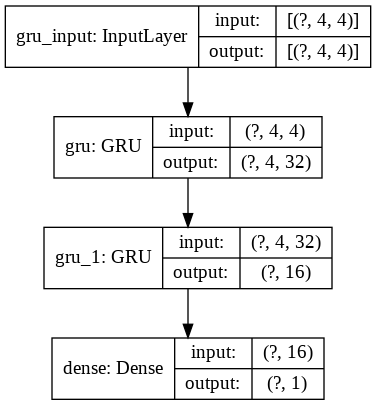

In [24]:
print(model_lat.summary())
tf.keras.utils.plot_model(model_lat, to_file='my_model.png', show_shapes=True, show_layer_names=True)

##Longtitude

In [0]:
model_long = tf.keras.models.Sequential()
model_long.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_long.shape[-2:]))
model_long.add(tf.keras.layers.GRU(16, activation='relu'))
model_long.add(tf.keras.layers.Dense(future_target))

model_long.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mse', 'mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 4, 32)             3648      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________
None


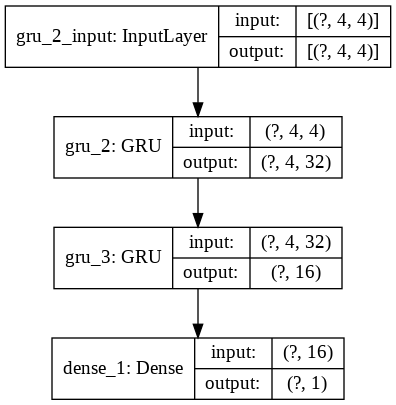

In [26]:
print(model_long.summary())
tf.keras.utils.plot_model(model_long, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Speed

In [0]:
model_wind = tf.keras.models.Sequential()
model_wind.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_wind.shape[-2:]))
model_wind.add(tf.keras.layers.GRU(16, activation='relu'))
model_wind.add(tf.keras.layers.Dense(future_target))

model_wind.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mse', 'mae'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 4, 32)             3648      
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________
None


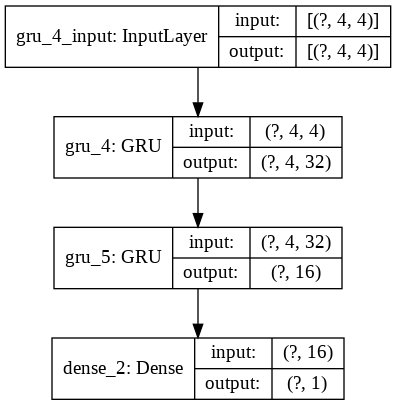

In [28]:
print(model_wind.summary())
tf.keras.utils.plot_model(model_wind, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Pressure

In [0]:
model_pres = tf.keras.models.Sequential()
model_pres.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_pres.shape[-2:]))
model_pres.add(tf.keras.layers.GRU(16, activation='relu'))
model_pres.add(tf.keras.layers.Dense(future_target))

model_pres.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mse', 'mae'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 4, 32)             3648      
_________________________________________________________________
gru_7 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________
None


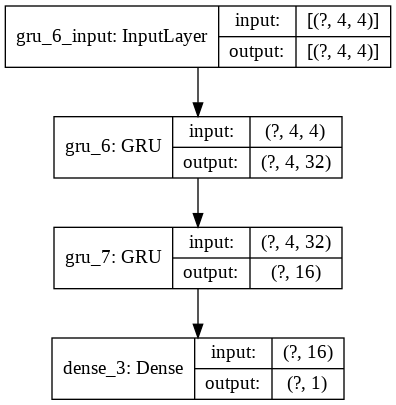

In [30]:
print(model_pres.summary())
tf.keras.utils.plot_model(model_pres, to_file='my_model.png', show_shapes=True, show_layer_names=True)

# Training & testing

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [0]:
def multi_step_plot(history, true_future, prediction, title=None):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

## Parameters

In [0]:
EPOCHS = 100
EPOCH_STEPS = TRAIN_SPLIT
VAL_STEPS = len(hurricane_SID) - TRAIN_SPLIT

## Latitude

In [34]:
multi_step_history = model_lat.fit(train_data_lat, epochs=EPOCHS,
                                          steps_per_epoch=EPOCH_STEPS,
                                          validation_data=val_data_lat,
                                          validation_steps=VAL_STEPS)

Train for 388 steps, validate for 98 steps
Epoch 1/100
388/388 [==============================] - 7s 18ms/step - loss: 0.1679 - mse: 0.0908 - mae: 0.1679 - val_loss: 0.2846 - val_mse: 0.1103 - val_mae: 0.2846
Epoch 2/100
388/388 [==============================] - 3s 6ms/step - loss: 0.0792 - mse: 0.0134 - mae: 0.0792 - val_loss: 0.2682 - val_mse: 0.0992 - val_mae: 0.2682
Epoch 3/100
388/388 [==============================] - 2s 6ms/step - loss: 0.1219 - mse: 0.0388 - mae: 0.1219 - val_loss: 0.2278 - val_mse: 0.0673 - val_mae: 0.2278
Epoch 4/100
388/388 [==============================] - 2s 6ms/step - loss: 0.1013 - mse: 0.0212 - mae: 0.1013 - val_loss: 0.3789 - val_mse: 0.1799 - val_mae: 0.3789
Epoch 5/100
388/388 [==============================] - 2s 6ms/step - loss: 0.0875 - mse: 0.0173 - mae: 0.0875 - val_loss: 0.2715 - val_mse: 0.1282 - val_mae: 0.2715
Epoch 6/100
388/388 [==============================] - 2s 6ms/step - loss: 0.0769 - mse: 0.0106 - mae: 0.0769 - val_loss: 0.1754 - 

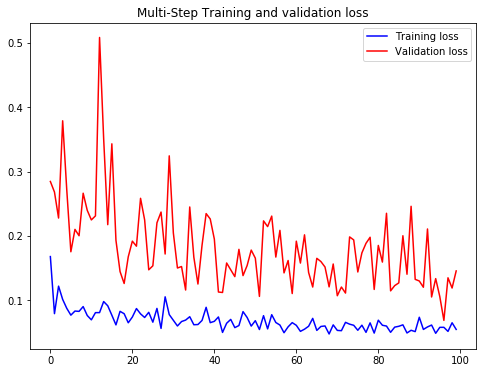

In [35]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

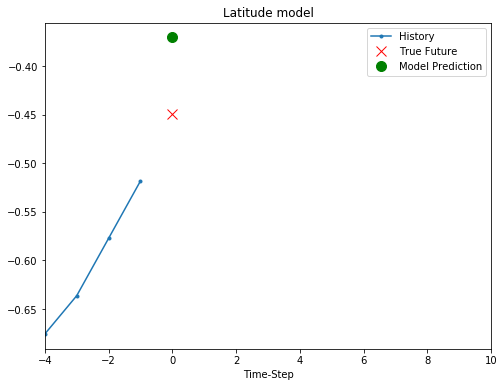

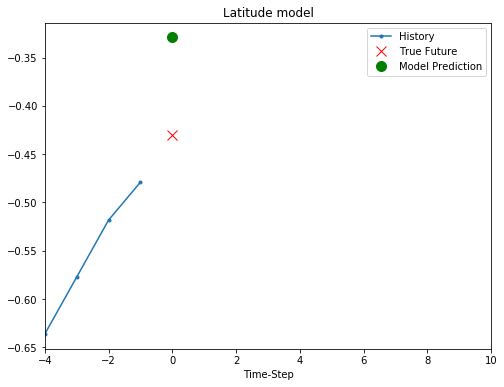

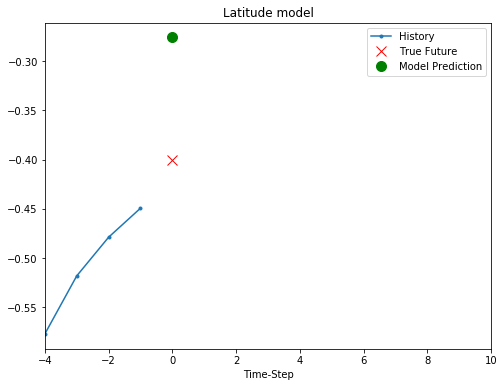

In [36]:
for x, y in val_data_lat.take(3):
  plot = show_plot([x[0][:,0].numpy(), y[0].numpy(),
                    model_lat.predict(x)[0]], 0, 'Latitude model')
  plot.show()

## Longtitude

In [0]:
multi_step_history = model_long.fit(train_data_long, epochs=EPOCHS,
                                          steps_per_epoch=EPOCH_STEPS,
                                          validation_data=val_data_long,
                                          validation_steps=VAL_STEPS)

Train for 388 steps, validate for 98 steps
Epoch 1/100
388/388 [==============================] - 8s 21ms/step - loss: 0.1647 - mse: 0.0811 - mae: 0.1647 - val_loss: 0.2618 - val_mse: 0.1355 - val_mae: 0.2618
Epoch 2/100
388/388 [==============================] - 3s 8ms/step - loss: 0.0739 - mse: 0.0115 - mae: 0.0739 - val_loss: 0.1699 - val_mse: 0.0496 - val_mae: 0.1699
Epoch 3/100
388/388 [==============================] - 3s 8ms/step - loss: 0.0747 - mse: 0.0118 - mae: 0.0747 - val_loss: 0.1463 - val_mse: 0.0327 - val_mae: 0.1463
Epoch 4/100
388/388 [==============================] - 3s 8ms/step - loss: 0.0578 - mse: 0.0061 - mae: 0.0578 - val_loss: 0.1512 - val_mse: 0.0393 - val_mae: 0.1512
Epoch 5/100
388/388 [==============================] - 3s 8ms/step - loss: 0.0823 - mse: 0.0172 - mae: 0.0823 - val_loss: 0.2061 - val_mse: 0.0538 - val_mae: 0.2061
Epoch 6/100
388/388 [==============================] - 3s 8ms/step - loss: 0.0547 - mse: 0.0073 - mae: 0.0547 - val_loss: 0.1992 - 

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [0]:
for x, y in val_data_long.take(3):
  plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                    model_long.predict(x)[0]], 0, 'Longitude model')
  plot.show()

## Wind Speed

In [0]:
multi_step_history = model_wind.fit(train_data_wind, epochs=EPOCHS,
                                          steps_per_epoch=EPOCH_STEPS,
                                          validation_data=val_data_wind,
                                          validation_steps=VAL_STEPS)

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [0]:
for x, y in val_data_wind.take(3):
  plot = show_plot([x[0][:,2].numpy(), y[0].numpy(),
                    model_wind.predict(x)[0]], 0, 'Wind Speed model')
  plot.show()

## Wind Pressure

In [0]:
multi_step_history = model_pres.fit(train_data_pres, epochs=EPOCHS,
                                          steps_per_epoch=EPOCH_STEPS,
                                          validation_data=val_data_pres,
                                          validation_steps=VAL_STEPS)

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [0]:
for x, y in val_data_pres.take(3):
  plot = show_plot([x[0][:,3].numpy(), y[0].numpy(),
                    model_pres.predict(x)[0]], 0, 'Wind Pressure model')
  plot.show()

In [0]:
for x, y in val_data_pres.take(3):
  multi_step_plot(tf.reshape(z, (1,4)), y, model_pres.predict(x)[0])

# Testing Data
Test network and plot paths on a map for a given storm.

In [0]:
lon_std = features['deg_north'].std()
lon_mean = features['deg_east'].mean()
lat_std = features['kt'].std()
lat_mean = features['mb'].mean()


def tensor_to_array(tensor1):
    return tensor1.numpy()

def un_normalize_long_lat(lon, lat):
  new_long = (lon_std * lon) + lon_mean
  new_lat = (lat_std * lat) + lat_mean
  return new_lat, new_long

In [0]:
def tuple_to_lists(list_tuples):
  list0 = []
  list1 = []
  for x,y in list_tuples:
    list0.append(x)
    list1.append(y)
  return list0, list1

In [0]:
def plot_storm_trajectory_prediction(storm):
  history = []
  expected = []
  actual = []
  for i in range(0,4):
    history.append((storm[i][0], storm[i][1]))

  input_x = np.array(storm[0:4])

  for i in range(4,8):

    x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])
    output_y = np.array(storm[i+1])
    y = output_y.reshape(1, output_y.shape[0], 1)

    predicted_lat = model_lat.predict(x)
    predicted_long = model_long.predict(x)
    predicted_wind = model_wind.predict(x)
    predicted_pres = model_pres.predict(x)

    predicted = [float(predicted_lat), float(predicted_long), float(predicted_wind), float(predicted_pres)]
    
    expected.append((storm[i][0], storm[i][1]))
    actual.append((predicted[0], predicted[1]))

    new_input = []
    for j in range(i-3,i):
      new_input.append(storm[j])
    new_input.append(predicted)
    input_x = np.array(new_input)

  return history, actual, expected

'''
ave_lat = sum(p[0] for p in actual)/len(actual)
ave_long = sum(p[1] for p in actual)/len(actual)

# Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_long], zoom_start=8)

plot_path_actual(actual,actual_pres, my_map)
plot_path_predicted(expected, expected_pres, my_map)


# Save map
my_map.save("./map8.html")
'''

In [0]:
for i in range(len(hurricane_SID)-10, len(hurricane_SID)):
  name = hurricane_SID[i]
  storm = hurricanes_by_SID[i]

  history, actual, expected = plot_storm_trajectory_prediction(storm)
  history_lat, history_long = tuple_to_lists(history)
  actual_lat, actual_long = tuple_to_lists(actual)
  expected_lat, expected_long = tuple_to_lists(expected)

  history_lat = np.array(history_lat)
  history_long = np.array(history_long)

  actual_lat = np.array(actual_lat)
  actual_long = np.array(actual_long)

  expected_lat = np.array(expected_lat)
  expected_long = np.array(expected_long)

  multi_step_plot(history_lat, expected_lat, actual_lat, name+" Latitude")
  multi_step_plot(history_long, expected_long, actual_long, name+" Longtitude")

  

